In [15]:
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.transform import iradon

from shape_synthesis.datasets.transforms import get_transform 
from shape_synthesis.datasets.mnist import DataConfig, create_dataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# When turning dev=True, the dataset will be created with a smaller number of points for faster testing; standard setting for the inverse
num_pts = 256
dev = True
res = 32
num_dir = 16
num_examples = 64

x_dim  = res * num_dir 

hidden_dim = 400
latent_dim = 100

hidden_dims_mlp = [64, 128, 256]

lr_vae = 1e-3
lr_mlp = 1e-3
batch_size = 64
epochs_vae = 150
epochs_mlp = 100

config = DataConfig(
        root="./data",
        raw="./data/raw",
        num_pts=num_pts,
        module="datasets.mnist",
        batch_size=None,
    )

dev
Creating: ./data/mnist
Creating: ./data/raw
Saving config to ./data/mnist/dev/config.yaml
Info
Min tensor([-0.7842, -0.7803])
Max tensor([0.6162, 0.5984])
Norm tensor(0.8590)
Info
Min tensor([-0.7842, -0.7803])
Max tensor([0.6162, 0.5984])
Norm tensor(0.8590)


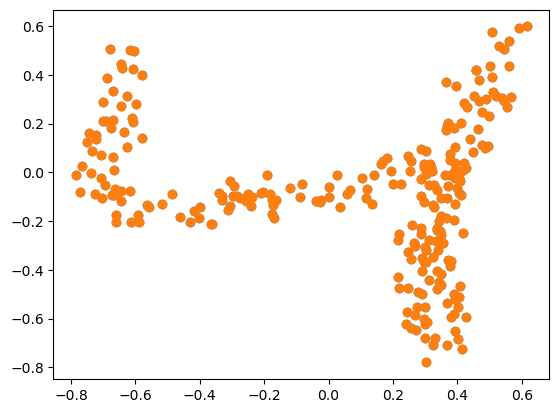

In [16]:
create_dataset(config, dev=dev)


train_pts = torch.load("./data/mnist/dev/train.pt")
train_imgs = torch.load("./data/mnist/dev/train_imgs.pt")

x = train_pts[2]
plt.scatter(x[:, 0], x[:, 1])

print(72 * "=")
print("Info")
print("Min", x.min(dim=0)[0])
print("Max", x.max(dim=0)[0])
print("Norm", torch.norm(x, dim=1).max())
print(72 * "=")

x = train_pts[2]
plt.scatter(x[:,0],x[:,1])


print(72*"=")
print("Info")
print("Min", x.min(dim=0)[0])
print("Max", x.max(dim=0)[0])
print("Norm", torch.norm(x,dim=1).max())
print(72*"=")

In [17]:
transform = get_transform(device=DEVICE, resolution=res, num_thetas=num_dir)
ect = transform(train_pts).movedim(-1,-1)
ect_tensor = torch.flatten(ect, start_dim=1)
labels = train_pts

full_dataset = TensorDataset(ect_tensor, train_pts)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

### Inversion of the ECT

Remark: This is part of active research, so not functional yet.

In [18]:
num_dir = 16
res = 256
id = 16
n_iterations = 32

transform = get_transform(device=DEVICE, resolution=res, num_thetas=num_dir, normalized=False, structured_directions=False)
test_ect = torch.round(transform(train_pts[:20])[id]*num_pts).transpose(0, 1)
test_ect[:, -1] = num_pts
test_cloud = x

RuntimeError: The size of tensor a (184) must match the size of tensor b (188) at non-singleton dimension 0

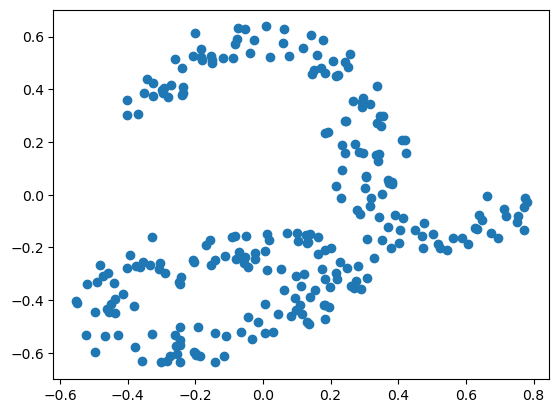

In [7]:
thetas = torch.nn.functional.normalize(transform.v, p=2, dim=0)
pts_coord = None


for i in range(n_iterations):
    lr = 1.0 * (0.95 ** i)              # decaying step
    for n_theta in range(num_dir):
        theta = thetas[:, n_theta]

        # 1) compute bin edges correctly
        proj = torch.matmul(test_cloud, theta)
        t_min, t_max = proj.min(), proj.max()
        delta_t = (t_max - t_min) / res

        coords_theta = []
        for n_step in range(res):
            n_pts  = int(test_ect[n_theta, n_step]) if n_step == 0 \
                     else int(test_ect[n_theta, n_step] -
                              test_ect[n_theta, n_step-1])

            if n_pts == 0:          # nothing to add in this cell
                continue

            height = t_min + (n_step + 0.5) * delta_t
            coords_theta.append(theta * height)

        if not coords_theta:
            continue

        pts_coord_theta = torch.stack(coords_theta)

        # 2) initial fill & update
        if pts_coord is None:
            pts_coord = pts_coord_theta.clone()
        else:
            sorted_old, idx_old = torch.sort(torch.matmul(pts_coord, theta))
            sorted_new, _       = torch.sort(torch.matmul(pts_coord_theta,
                                                         theta))

            delta = (sorted_new - sorted_old).unsqueeze(1)
            _, inv = torch.sort(idx_old)
            pts_coord += lr * delta[inv] * theta / theta.square().sum()

# centre + isotropic scale
pts_coord -= pts_coord.mean(0, keepdim=True)
test_cloud -= test_cloud.mean(0, keepdim=True)
scale = test_cloud.norm(dim=1).max() / pts_coord.norm(dim=1).max()
pts_coord *= scale

# Plotting
plt.scatter(pts_coord[:, 0].cpu(), pts_coord[:, 1].cpu(), color='red', label='Reconstructed Points')
plt.scatter(test_cloud[:, 0].cpu(), test_cloud[:, 1].cpu(), color='blue', label='Original Points')
plt.legend()
plt.show()

In [20]:
transform = get_transform(
    device=DEVICE,
    resolution=res,
    num_thetas=num_dir,
    normalized=True,
    structured_directions=True,
)

# Original point cloud
x = train_pts[id]

# ---- 2. Get Transform Output (Sinogram-like data) ----
test_ect = transform(train_pts[:20])[id] # shape (num_thetas, resolution)
test_ect = test_ect.transpose(0, 1).cpu().numpy()

# Convert cumulative counts to Radon projections (discrete derivative)
radon_proj = np.diff(test_ect, axis=1, prepend=0)

# Reshape to (resolution, num_dir) for iradon
sinogram = radon_proj #  test_ect

# ---- 3. Compute Correct Angles from v ----
v = transform.v.cpu()  # shape (2, num_dir)
v_np = v.numpy().T     # shape (num_dir, 2)

angles = np.arcsin(v_np[:,0])*180/np.pi

# ---- 4. Radon-Based Reconstruction ----
reconstruction = iradon(sinogram, theta=angles, filter_name="ramp")

# ---- 5. Convert Reconstruction to Point Cloud ----
# Threshold: keep pixels above a fraction of max value
threshold = reconstruction.max() * 0.7  # tweak (0.3–0.7 works well)
y_coords, x_coords = np.where(reconstruction > threshold)
reconstructed_cloud = np.stack([x_coords, y_coords], axis=-1).astype(float)


# ---- 7. Plot Original vs Reconstructed ----
plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), color='blue', alpha=0.6, label='Original Points')
plt.scatter(reconstructed_cloud[:, 0], reconstructed_cloud[:, 1], color='red', alpha=0.6, label='Reconstructed (Radon)')
plt.legend()
plt.axis("equal")
plt.title("Original vs Radon-Reconstructed Point Cloud")
plt.show()

ValueError: The given ``theta`` does not match the number of projections in ``radon_image``.

/Users/jschmidt/micromamba/envs/shape-synthesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 800/800 [01:05<00:00, 12.14it/s]


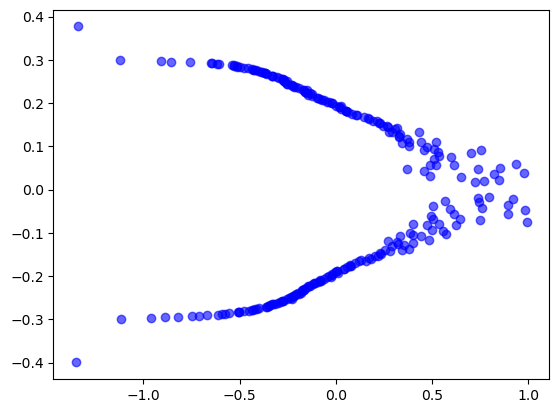

In [9]:
import torch
from torch import nn
from tqdm.auto import trange

# ----------
#  data
# ----------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pts_true   = train_pts[id].to(device)                     # (N,2)
num_pts, dim = pts_true.shape

# ---- 1. Parameters & Transform ----
num_dir = 512           # number of directions (adjust as needed)
res = 512               # resolution
id = 16                # which point cloud to reconstruct
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = get_transform(
    device=DEVICE,
    resolution=res,
    num_thetas=num_dir,
    normalized=True,
    structured_directions=True
)

# Original point cloud
x = train_pts[id]

thetas      = transform.v.to(device)                      # (dim,K)
thetas      = nn.functional.normalize(thetas, p=2, dim=0)

# pre-computed (un-rounded!) cumulative ECT of the true cloud
C_true = transform(train_pts[:20])[id].transpose(0, 1).to(device)         # (K,R)

# thresholds shared by both clouds
t_vals = torch.linspace(C_true.min(), C_true.max(), res,
                        device=device)                    # (R,)

# ----------
#  model
# ----------
eps      = 1e-2                      # soft-Heaviside width
lam_cvg  = 1e-2                      # regulariser weight
init_std = 0.05 * pts_true.norm()    # random init around origin

points = nn.Parameter(init_std * torch.randn_like(pts_true))

opt = torch.optim.AdamW([points], lr=5e-2)

def soft_cumECT(P):                  # P : (N,2)
    # P has to be (N,2); θ is (2,K); output (K,R)
    proj = P @ thetas                # (N,K)
    # broadcast: (N,K,R) = (N,K,1) - (R,)
    z = (t_vals[None,None,:] - proj[:,:,None]) / eps
    H = torch.sigmoid(z)             # (N,K,R)
    return H.sum(dim=0)              # (K,R)

def loss_fn():
    C_hat = soft_cumECT(points)
    mse   = (C_hat - C_true).pow(2).mean()
    cov   = torch.cov(points.T)
    reg   = (cov - torch.eye(dim, device=device)).pow(2).sum()
    return mse + lam_cvg * reg

# ----------
#  training
# ----------
for step in trange(800):
    opt.zero_grad()
    loss = loss_fn()
    loss.backward()
    opt.step()

# optional: recenter and scale to true cloud afterwards
with torch.no_grad():
    P   = points - points.mean(0, keepdim=True)
    P  *= pts_true.std() / P.std()

plt.scatter(P[:,0], P[:,1], c='blue', alpha=0.6)

(512, 512)


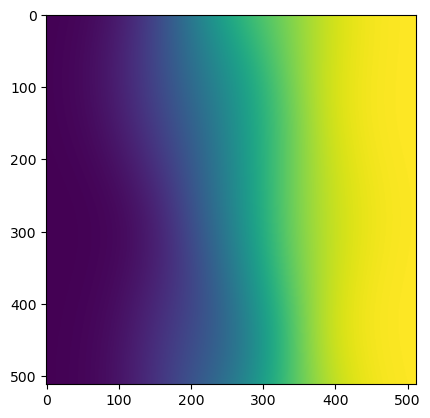

In [10]:
sinogram = test_ect.transpose(0,1)
print(test_ect.shape)

theta = torch.linspace(0, 180, num_dir).numpy()

reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')*100

plt.imshow(test_ect)
#plt.imshow(reconstruction_fbp*100)
plt.show()

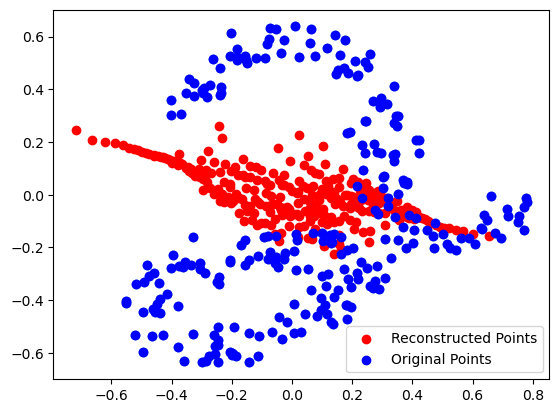

In [11]:
num_dir = 32
res = 256
id = 16

transform = get_transform(device=DEVICE, resolution=res, num_thetas=num_dir, normalized=False, structured_directions=True)
x = train_pts[id]
plt.scatter(x[:, 0], x[:, 1])
test_ect = torch.round(transform(train_pts[:20])[id]*num_pts).transpose(0, 1)
test_ect[:, -1] = num_pts
test_cloud = x

thetas = transform.v

pts_coord = None
for n_theta in torch.arange(num_dir):
    theta = thetas[:, n_theta]
    coords_list = []
    for n_step in range(res):
        n_pts = int(test_ect[n_theta, n_step]) if n_step == 0 else int(test_ect[n_theta, n_step] - test_ect[n_theta, n_step-1])
        
        if n_pts <= 0:
            continue  # Skip problematic repetitions
        
        coords_step = theta.unsqueeze(0).repeat(n_pts, 1) * n_step
        coords_list.append(coords_step)
    
    if not coords_list:
        continue  # If no points were added, skip
    
    pts_coord_theta = torch.cat(coords_list, dim=0)

    if pts_coord is None:
        pts_coord = pts_coord_theta
    else:
        sorted_proj, indices = torch.sort(torch.matmul(pts_coord, theta))
        sorted_proj_theta, _ = torch.sort(torch.matmul(pts_coord_theta, theta))
        
        delta = torch.trunc(sorted_proj_theta - sorted_proj).unsqueeze(1)
        
        _, inverse_indices = torch.sort(indices)
        pts_coord = pts_coord + delta[inverse_indices] * theta.unsqueeze(0)

# Center reconstructed point cloud
pts_coord = pts_coord - pts_coord.mean(dim=0, keepdim=True)

# Center original point cloud
original_cloud = test_cloud - test_cloud.mean(dim=0, keepdim=True)

# Scale reconstructed point cloud to match original size
scale_factor = original_cloud.norm(dim=1).max() / pts_coord.norm(dim=1).max()
pts_coord = pts_coord * scale_factor

# Plotting
plt.scatter(pts_coord[:, 0].cpu(), pts_coord[:, 1].cpu(), color='red', label='Reconstructed Points')
plt.scatter(test_cloud[:, 0].cpu(), test_cloud[:, 1].cpu(), color='blue', label='Original Points')
plt.legend()
plt.show()